(mobility-activity)=
# Estimating Activity Using Mobility Data

Understanding population movement can provide valuable insights for public policy and disaster response efforts, particularly during crises when less movement often correlates with reduced economic activity.

Similar to initiatives such as the [COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/), [Facebook Population During Crisis](https://dataforgood.facebook.com/dfg/tools/facebook-population-maps), and [Mapbox Movement Data](https://www.mapbox.com/movement-data), we have developed a range of crisis-relevant indicators. These include baseline and subsequent device densities, as well as metrics like **percent change** and **z-score**. These indicators are derived by aggregating device counts within specific geographical tiles and across various time periods, utilizing longitudinal mobility data.

It's important to note the inherent limitations associated with this approach, as detailed in {ref}`mobility-activity-limitations`. Notably, mobility data is typically collected through convenience sampling methods and lacks the controlled methodology of randomized trials.

In [3]:
# !pip install pandas "dask[complete]" pyarrow plotly
# !pip install --upgrade s3fs
# !pip install datashader
# !pip install geopandas
# !pip install h3
# !pip install folium
# !pip install matplotlib
# !pip install mapclassify
# !pip install seaborn


import dask.dataframe as dd
import seaborn as sns

sns.set()
import matplotlib.ticker as ticker
import geopandas as gpd
import shapely
import h3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
from dask.distributed import Client

client = Client(n_workers=1)
client

<Client: 'tcp://127.0.0.1:40197' processes=1 threads=64, memory=249.02 GiB>

## Data

In this section, we import from the data sources, available either publicly or via {ref}`data`.

In [5]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
PANEL = "v2023.10"

### Area of Interest 

In this step, we import the SEZ points and create a buffer of 30 km around them. Later, we do a tessellation with h3 polygons of level 6. The resulting tessellation can be explored below.

In [6]:
def get_h3_tessellation(gdf: gpd.GeoDataFrame, name="shapeName", resolution=10):
    mapper = dict()
    h3_tessellation = set()

    # TODO: vectorize, if possible
    for idx, row in gdf.iterrows():
        geometry = row["geometry"]

        match geometry.geom_type:
            case "Polygon":
                hex_ids = h3.polyfill(
                    shapely.geometry.mapping(geometry),
                    resolution,
                    geo_json_conformant=True,
                )

                h3_tessellation = h3_tessellation.union(set(hex_ids))
                mapper.update([(hex_id, row[name]) for hex_id in hex_ids])

            case "MultiPolygon":
                for x in geometry.geoms:
                    hex_ids = h3.polyfill(
                        shapely.geometry.mapping(x),
                        resolution,
                        geo_json_conformant=True,
                    )

                    h3_tessellation = h3_tessellation.union(set(hex_ids))
                    mapper.update([(hex_id, row[name]) for hex_id in hex_ids])
            case _:
                raise (Exception)

    return mapper, h3_tessellation


from shapely import Polygon


def cell_to_shapely(h3_id):
    coords = h3.h3_to_geo_boundary(h3_id, geo_json=True)
    flipped = tuple(coord for coord in coords)
    return Polygon(flipped)

In [7]:
sez = gpd.read_file("./data/sez/industrial__special_economic_zones_sept2019.shp")
sez = sez.to_crs("EPSG:32646")
sez["buffer"] = sez.geometry.apply(lambda x: x.buffer(30000))
sez.drop("geometry", axis=1, inplace=True)
sez.rename(columns={"buffer": "geometry"}, inplace=True)
sez.set_geometry("geometry", inplace=True)
sez = sez.to_crs("epsg:4326")
mapper, h3_tessellation = get_h3_tessellation(sez, name="Name", resolution=6)
df_tess = pd.DataFrame(h3_tessellation)
df_tess.rename(columns={0: "hex_id"}, inplace=True)
df_tess["geometry"] = df_tess["hex_id"].apply(lambda x: cell_to_shapely(x))
AOI = gpd.GeoDataFrame(data=df_tess, geometry=df_tess.geometry, crs="epsg:4326")
AOI["Name"] = AOI["hex_id"].apply(lambda x: mapper[x])
AOI.to_file("sez_hex3_6.gpkg")

In [8]:
admin1 = gpd.read_file("./data/mmr_polbnda_adm2_250k_mimu_1.shp")
mapper_a1, h3_tessellation_a1 = get_h3_tessellation(admin1, name="ST", resolution=6)
df_tess_a1 = pd.DataFrame(h3_tessellation_a1)
df_tess_a1.rename(columns={0: "hex_id"}, inplace=True)
df_tess_a1["geometry"] = df_tess_a1["hex_id"].apply(lambda x: cell_to_shapely(x))
admin1_h3 = gpd.GeoDataFrame(
    data=df_tess_a1, geometry=df_tess_a1.geometry, crs="epsg:4326"
)
admin1_h3["Name"] = admin1_h3["hex_id"].apply(lambda x: mapper_a1[x])

admin1_h3.to_file("admin1_hex3_6.gpkg")

In [9]:
AOI.explore()

### Mobility Data

The WB Data Lab team has acquired longitudinal human mobility data encompassing anonymized timestamped geographical points generated by GPS-enabled devices located in Myanmar. The dataset we are using for this analysis spans across 2020.

The project team has utilized the longitudinal mobility data to derive several key metrics. Specifically, we compute baseline and subsequent device densities, denoted as `n_baseline` and `count` respectively, along with metrics such as **percent change** (`percent_change` and [**Z-score**](https://en.wikipedia.org/wiki/Standard_score) (`z-score`). These indicators are derived by aggregating the device count within each tile and at each time period. The devices are sourced from the longitudinal mobility data. For further details, please refer to the documentation provided in {ref}`mobility-data` and {ref}`mobility-activity-methodology`.

In [11]:
path = "./data/data_2020*.parquet"
columns = ["uid", "datetime", "hex_id"]
ddf = dd.read_parquet(path, columns=columns)

First, we calculate the cardinality, 

In [12]:
len(ddf)

561632137

(mobility-activity-methodology)=

## Methodology

The methodology presented consists of generating a series of crisis-relevant metrics, including the baseline(sample) `population density`, `percent change` and `z-score` based on the number of devices in an area at a time. The device count is determined for each tile and for each time period, as defined by data standards and the spatial and temporal aggregations below. Similar approaches have been adopted, such as in {cite}`10.1145/3292500.3340412`. The metrics may reveal movement trends in the sampled population that may indicate more or less activity. 

### Data Standards

#### Population Sample

The sampled population is composed of GPS-enabled devices drawn out from longituginal mobility data. It is important to emphasize the sampled population is obtained via convenience sampling and that the mobility data panel represents only a subset of the total population in an area at a time, specifically only users that turned on location tracking on their mobile device. Thus, derived metrics do not represent the total population density.

#### Spatial Aggregation 

The indicators are aggregated spatially on [H3 resolution 6](https://h3geo.org) tiles. This is equivalent to approximately to an area of $36 Km^2$ on average as illustrated below.

In [13]:
AOI[AOI["Name"] == "Ponnagyun Industrial Zone"].explore()

#### Temporal Aggregation 

The indicators are aggregated daily on the localized date in the **Europe/Istanbul (UTC+3)** timezone.

### Implementation 

#### Calculate `ACTIVITY`

In this step, we compute `ACTIVITY` as a density metric. Specifically, we tally the total number of devices detected within each designated area of interest, aggregated on a daily basis. It's important to highlight that this calculation is based on a spatial join approach, which determines whether a device has been detected within an area of interest at least once. This method, while straightforward, represents a simplified approach compared to more advanced techniques such as estimating stay locations and visits.

In [14]:
path = "./data/data_2020*.parquet"
columns = ["uid", "datetime", "hex_id"]
ddf = dd.read_parquet(path, columns=columns)
ACTIVITY = (
    ddf.assign(date=lambda x: dd.to_datetime(ddf["datetime"].dt.date))
    .groupby(["hex_id", "date"])["uid"]
    .nunique()
    .to_frame("count")
    .reset_index()
    .compute()
)

In [15]:
# change to hex_id level 6
ACTIVITY.rename(columns={"hex_id": "hex_id_7"}, inplace=True)
ACTIVITY["hex_id"] = ACTIVITY["hex_id_7"].apply(lambda x: h3.h3_to_parent(x, 6))
ACTIVITY.drop("hex_id_7", axis=1, inplace=True)
ACTIVITY = ACTIVITY.groupby(["date", "hex_id"])["count"].sum().to_frame("count")
ACTIVITY.reset_index(inplace=True)

Additionally, we create a column `weekday` that will come handy later on when standardizing. 

In [16]:
ACTIVITY["weekday"] = ACTIVITY["date"].dt.weekday

#### Calculate `BASELINE`

In this step, we choose the period spanning January 1, 2020 to February 29, 2020 as the baseline. The baseline is calculated for each tile and for each time period, according to the [spatial](#spatial-aggregation) and [temporal](#temporal-aggregation) aggregations. 

In [17]:
BASELINE = ACTIVITY[ACTIVITY["date"].between("2020-01-01", "2020-02-29")]

In fact, the result are 7 different baselines for each tile. We calculate the mean device density for each tile and for each day of the week (Mon-Sun). 

In [18]:
MEAN = BASELINE.groupby(["hex_id", "weekday"]).agg({"count": ["mean", "std"]})

Taking a sneak peek, 

In [19]:
MEAN.columns = MEAN.columns.map(".".join)

In [20]:
MEAN.head()

count.mean  count.std
hex_id          weekday                       
863c59607ffffff 2               1.0        NaN
                3               1.0        NaN
863c5a207ffffff 2               1.0        NaN
863c5a22fffffff 2               1.0        NaN
863c5a29fffffff 0               1.0        NaN

In [21]:
MEAN.loc["86648c127ffffff"]

count.mean   count.std
weekday                        
0        513.625000  134.469261
1        438.125000   90.981062
2        544.000000  199.530699
3        466.555556   84.643534
4        637.888889  106.473523
5        642.666667  148.873268
6        601.500000  249.296725

In [22]:
len(BASELINE[BASELINE["hex_id"] == "86648c127ffffff"])

60

#### Calculate `Z-Score` and **Percent Change**

A z-score serves as a statistical metric indicating the deviation of a specific data point from the mean (average) of a given dataset, expressed in terms of standard deviations. It is particularly valuable for standardizing and facilitating meaningful comparisons across various datasets. By evaluating the z-scores, one can gauge the extent to which a dataset diverges from its mean, while accounting for variance. Conversely, a percent change offers a simpler interpretation but lacks the detailed information provided by z-scores.

Creating `StandardScaler` for each `hex_id`,

In [23]:
scalers = {}

for hex_id in BASELINE["hex_id"].unique():
    scaler = StandardScaler()
    scaler.fit(BASELINE[BASELINE["hex_id"] == hex_id][["count"]])

    scalers[hex_id] = scaler

Joining with the area of interest (`AOI`),

In [24]:
ACTIVITY = ACTIVITY.merge(AOI, how="left", on="hex_id").drop(["geometry"], axis=1)

Finally, merging with the (mean) baseline,

In [25]:
ACTIVITY = pd.merge(ACTIVITY, MEAN, on=["hex_id", "weekday"], how="left")

Calculating the `z_score` for each tile,

In [26]:
for hex_id, scaler in scalers.items():
    try:
        predicate = ACTIVITY["hex_id"] == hex_id
        score = scaler.transform(ACTIVITY[predicate][["count"]])
        ACTIVITY.loc[predicate, "z_score"] = score
    except Exception:
        pass

Additionally, we calculate the **percent change**. While the **z-score** offers more robustness to outliers and numerical stability, the **percent change** can be used when interpretability is most important. Thus, preparing columns, 

In [27]:
ACTIVITY["n_baseline"] = ACTIVITY["count.mean"]
ACTIVITY["n_difference"] = ACTIVITY["count"] - ACTIVITY["n_baseline"]

In [28]:
ACTIVITY["percent_change"] = 100 * (ACTIVITY["count"] / (ACTIVITY["n_baseline"]) - 1)

In [29]:
ACTIVITY.to_csv("activity.csv", index=False)

Taking a sneak peek, 

In [9]:
ACTIVITY = pd.read_csv("activity.csv")

In [10]:
ACTIVITY

date           hex_id  count  weekday Name  count.mean  \
0        2020-01-01  863c5b06fffffff      1        2  NaN    1.000000   
1        2020-01-01  863c5b217ffffff      1        2  NaN    4.800000   
2        2020-01-01  863c5b28fffffff     17        2  NaN   41.777778   
3        2020-01-01  863c5b2f7ffffff     11        2  NaN   24.888889   
4        2020-01-01  863c5b38fffffff      1        2  NaN    1.666667   
...             ...              ...    ...      ...  ...         ...   
1502945  2020-12-31  8664f676fffffff      1        3  NaN    8.750000   
1502946  2020-12-31  8664f6c87ffffff      1        3  NaN    2.666667   
1502947  2020-12-31  8664f6cdfffffff      2        3  NaN    5.666667   
1502948  2020-12-31  8664f6db7ffffff      1        3  NaN    4.625000   
1502949  2020-12-31  86658932fffffff      1        3  NaN    6.375000   

         count.std   z_score  n_baseline  n_difference  percent_change  
0              NaN  0.000000    1.000000      0.000000        0.000000  
1         4.969909 -0.710440    4.800000     -3.800000      -79.166667  
2        31.252111 -0.733637   41.777778    -24.777778      -59.308511  
3        20.164600 -0.728482   24.888889    -13.888889      -55.803571  
4         0.577350 -0.846228    1.666667     -0.666667      -40.000000  
...            ...       ...         ...           ...             ...  
1502945   5.700877 -1.205869    8.750000     -7.750000      -88.571429  
1502946   2.081666 -1.023090    2.666667     -1.666667      -62.500000  
1502947   2.516611 -0.519846    5.666667     -3.666667      -64.705882  
1502948   2.445842 -1.138637    4.625000     -3.625000      -78.378378  
1502949   4.533605 -1.213225    6.375000     -5.375000      -84.313725  

[1502950 rows x 11 columns]

In [11]:
ACTIVITY = ACTIVITY[(ACTIVITY["count"] >= 10) | (ACTIVITY["n_baseline"] >= 10)]
ACTIVITY = ACTIVITY[(ACTIVITY["z_score"] <= 10)]

In [12]:
ACTIVITY[
    [
        "hex_id",
        "date",
        "count",
        "n_baseline",
        "n_difference",
        "percent_change",
        "z_score",
        "Name",
    ]
].sort_values(["hex_id", "date"], ascending=False)

hex_id        date  count  n_baseline  n_difference  \
221430   86658935fffffff  2020-02-12     10    3.200000      6.800000   
80965    86658935fffffff  2020-01-17     11    2.750000      8.250000   
1490422  86658932fffffff  2020-12-28      8   10.625000     -2.625000   
1477934  86658932fffffff  2020-12-26      3   11.111111     -8.111111   
1467787  86658932fffffff  2020-12-24     14    6.375000      7.625000   
...                  ...         ...    ...         ...           ...   
6114     863c5b28fffffff  2020-01-03     25   37.666667    -12.666667   
3045     863c5b28fffffff  2020-01-02      5   28.555556    -23.555556   
2        863c5b28fffffff  2020-01-01     17   41.777778    -24.777778   
142474   863c5b217ffffff  2020-01-29     12    4.800000      7.200000   
97151    863c5b217ffffff  2020-01-21     11    3.200000      7.800000   

         percent_change   z_score Name  
221430       212.500000  2.576855  NaN  
80965        300.000000  2.942078  NaN  
1490422      -24.705882 -0.080882  NaN  
1477934      -73.000000 -0.889698  NaN  
1467787      119.607843  0.889698  NaN  
...                 ...       ...  ...  
6114         -33.628319 -0.392411  NaN  
3045         -82.490272 -1.245477  NaN  
2            -59.308511 -0.733637  NaN  
142474       150.000000  3.244059  NaN  
97151        243.750000  2.884559  NaN  

[526220 rows x 8 columns]

## Findings 

Less movement typically means less economic activity. A potential use of movement "activity" indicators could be to see the their evolution in time and correlatation to other features. We present the results (i.e., `percent_change` and `z_score`) on Speial Economic Zones, Administrative 1 boundaries and on the defined Regions. 

Aggregation method: Activity index calculated at h3 level 6 was aggregated, first, by averaging the values across the SEZ, Admin 1 or Region, daily. Later, a weekly aggregation was performed. 

### By Special Economic Zones

#### Percentage Change

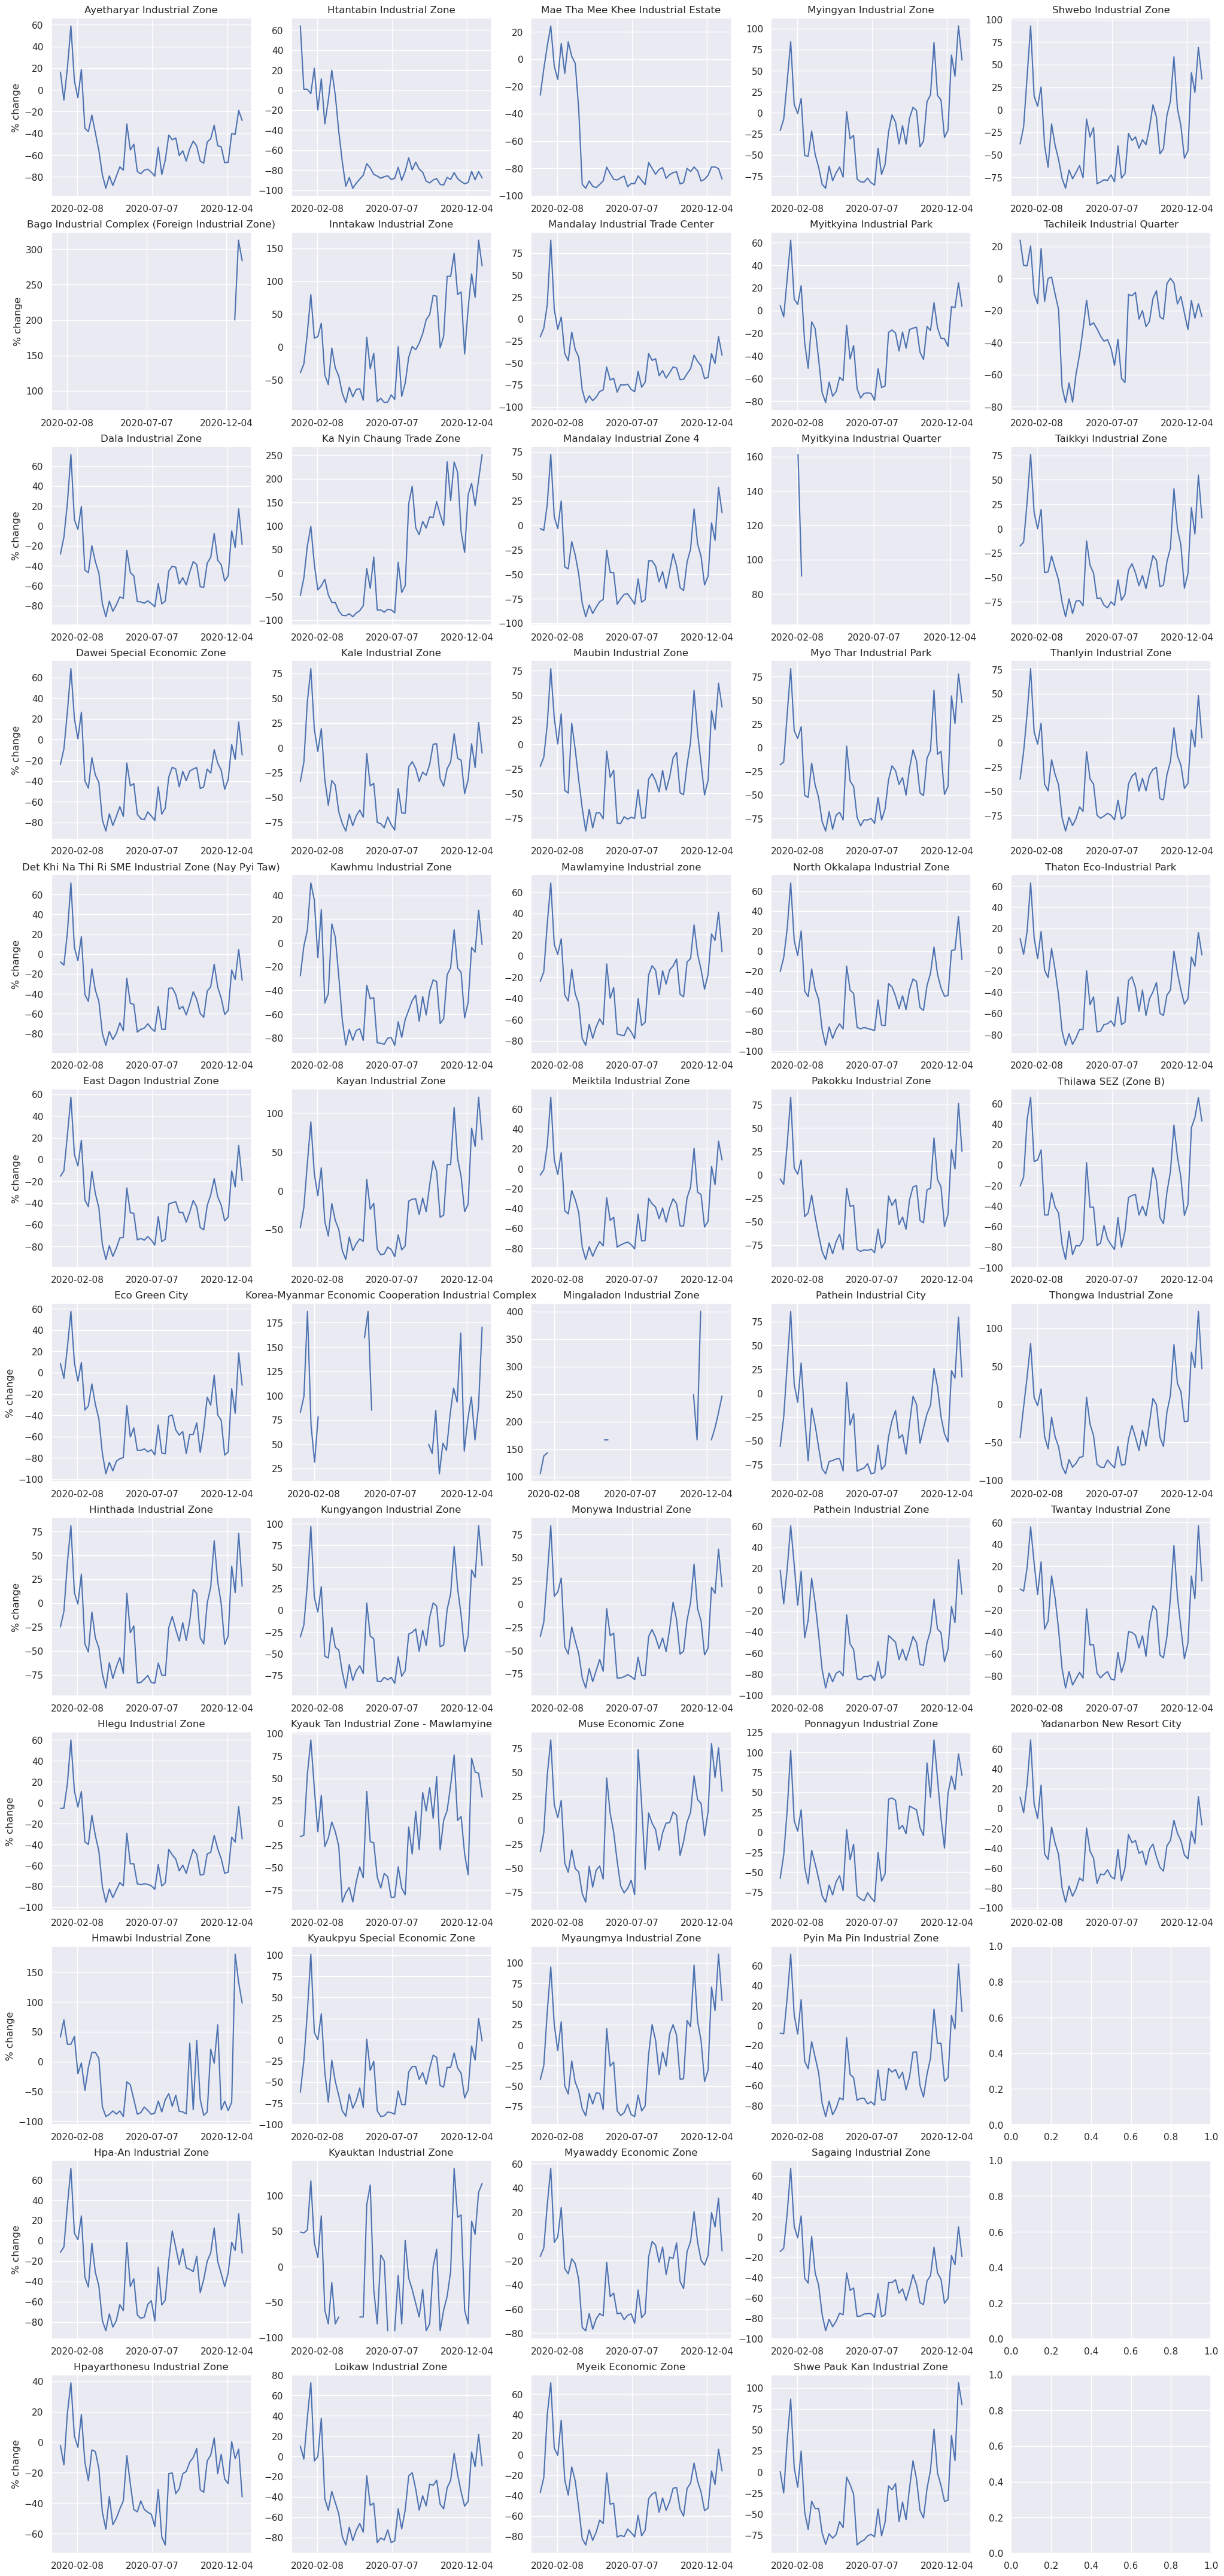

In [24]:
FREQ = "W"

data = ACTIVITY.groupby(["date", "Name"])["percent_change"].mean().to_frame()
data = data.pivot_table(values=["percent_change"], index=["date"], columns=["Name"])
data.columns = [x[1] for x in data.columns]
data.index = pd.to_datetime(data.index)
data = data.groupby(pd.Grouper(freq=FREQ)).mean()

fig, ax = plt.subplots(nrows=12, ncols=5, figsize=(25, 55))
count = 0
names = data.columns
for j in range(5):
    for i in range(12):
        ax[i, j].plot(data[names[count]])
        ax[i, j].title.set_text(names[count])
        ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
        count += 1
        if j == 0:
            ax[i, j].set_ylabel("% change")
        if count > 56:
            break
plt.savefig("percentage_change.png")

#### Z-Score

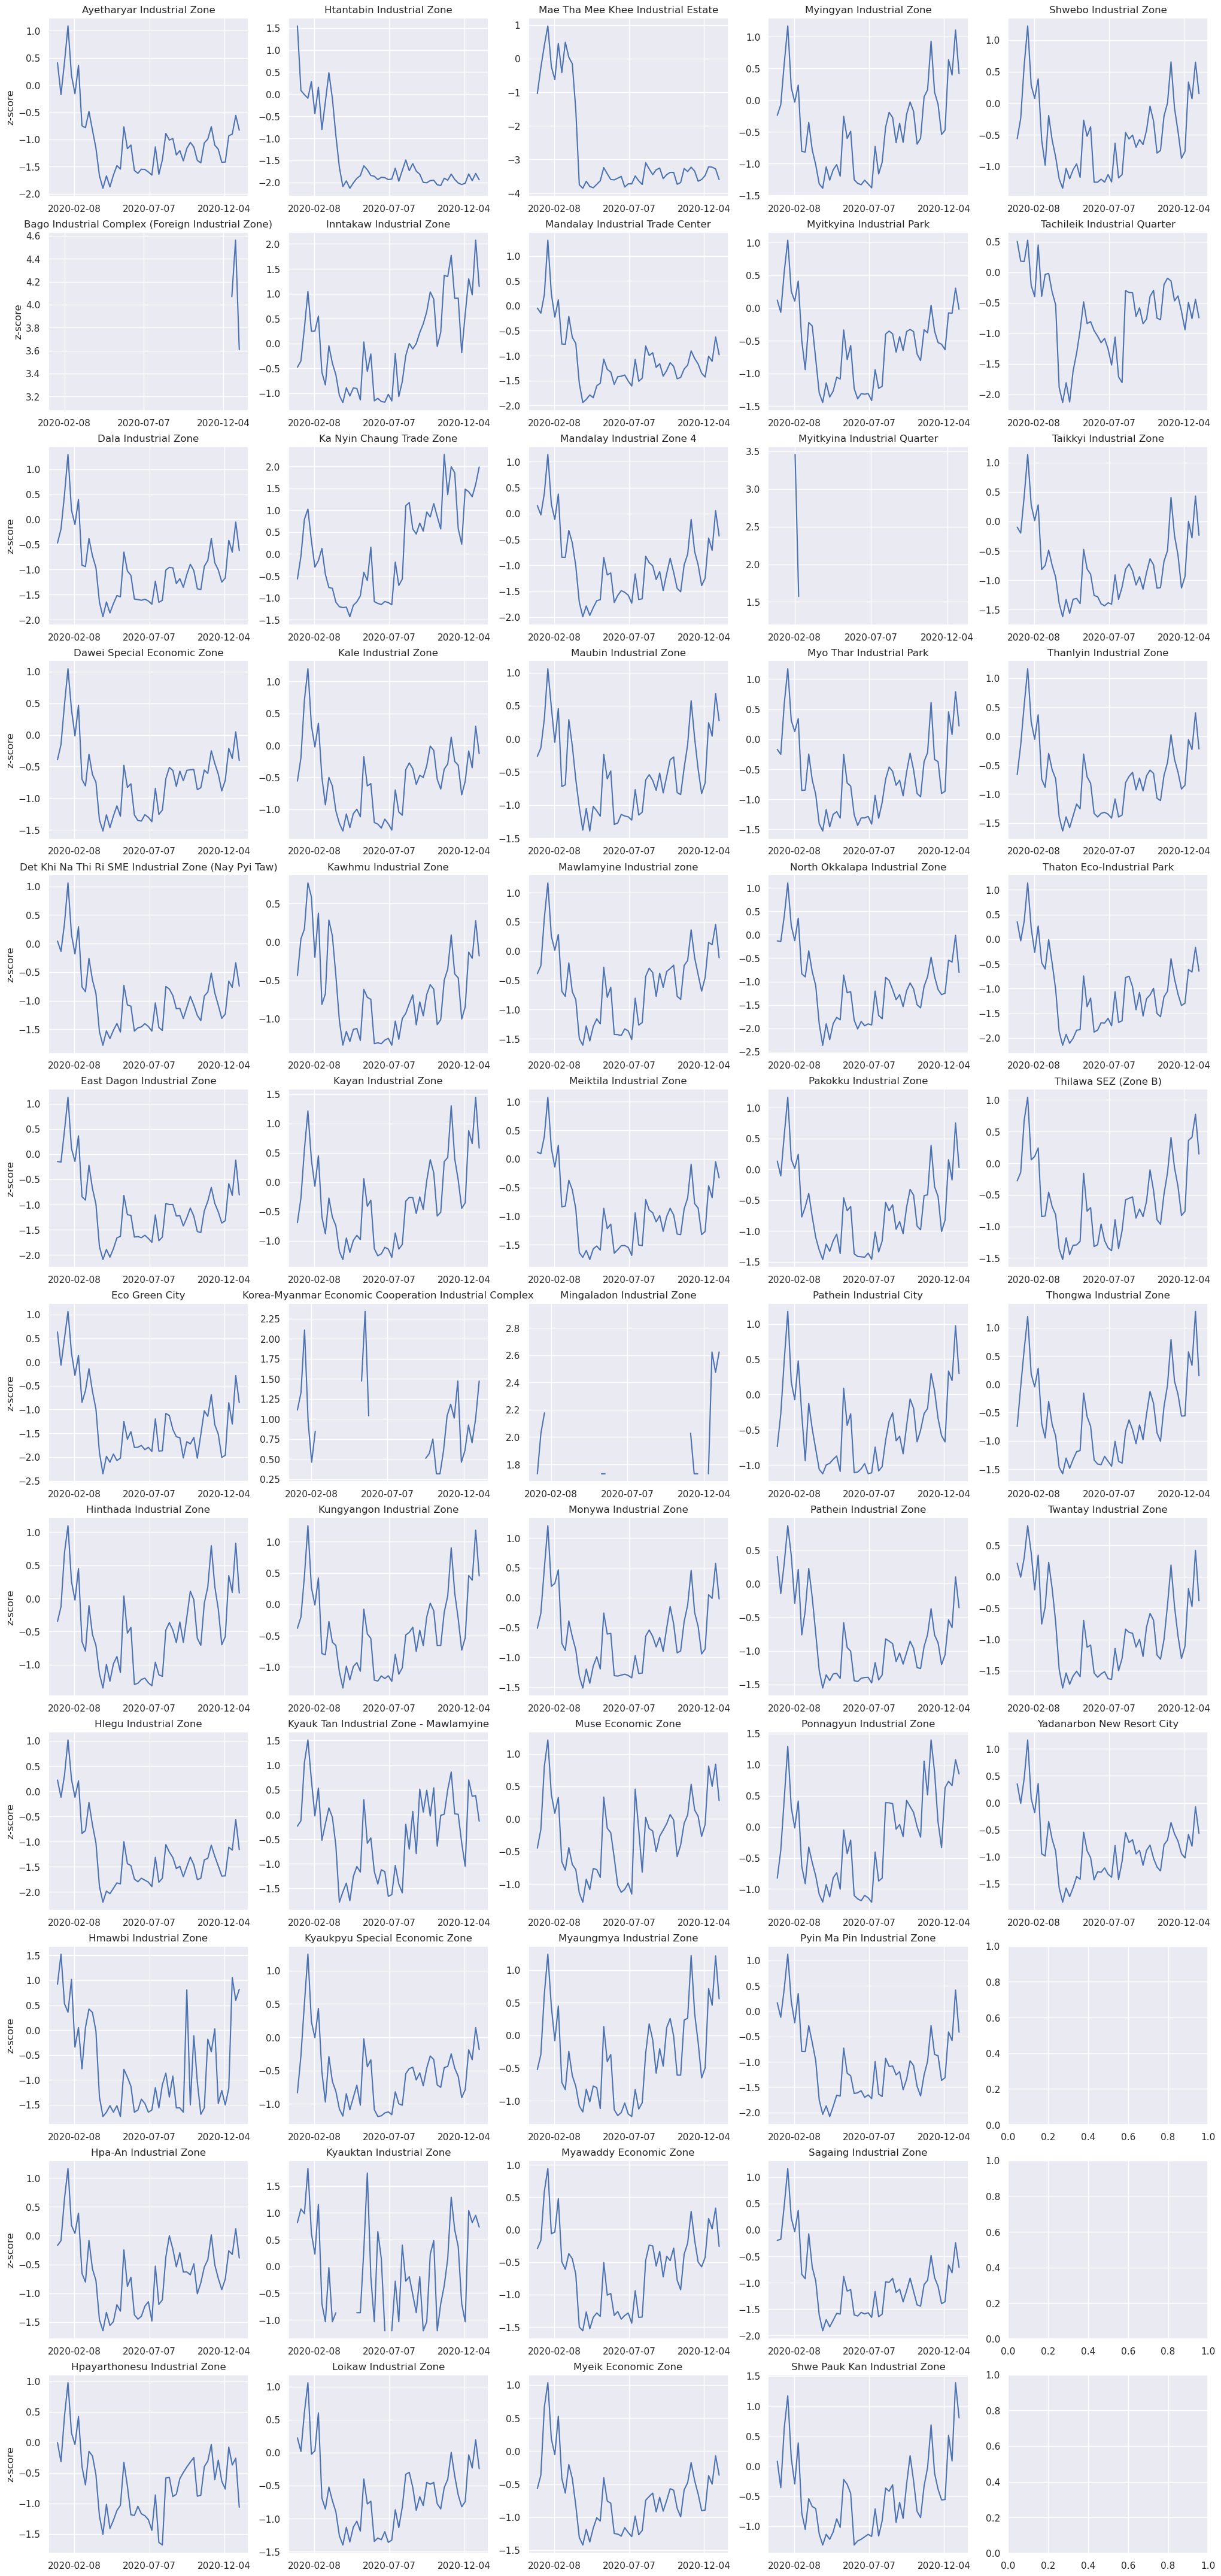

In [26]:
FREQ = "W"

data = ACTIVITY.groupby(["date", "Name"])["z_score"].mean().to_frame()
data = data.pivot_table(values=["z_score"], index=["date"], columns=["Name"])
data.columns = [x[1] for x in data.columns]
data.index = pd.to_datetime(data.index)
data = data.groupby(pd.Grouper(freq=FREQ)).mean()

fig, ax = plt.subplots(nrows=12, ncols=5, figsize=(25, 55))
count = 0
names = data.columns
for j in range(5):
    for i in range(12):
        ax[i, j].plot(data[names[count]])
        ax[i, j].title.set_text(names[count])
        ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

        count += 1
        if j == 0:
            ax[i, j].set_ylabel("z-score")
        if count > 56:
            break
plt.savefig("z_score.png")

### By Admin 1

In [27]:
ACTIVITY = ACTIVITY.merge(
    admin1_h3.rename(columns={"Name": "admin1"}),
    left_on="hex_id",
    right_on="hex_id",
    how="left",
)

#### Percentage Change

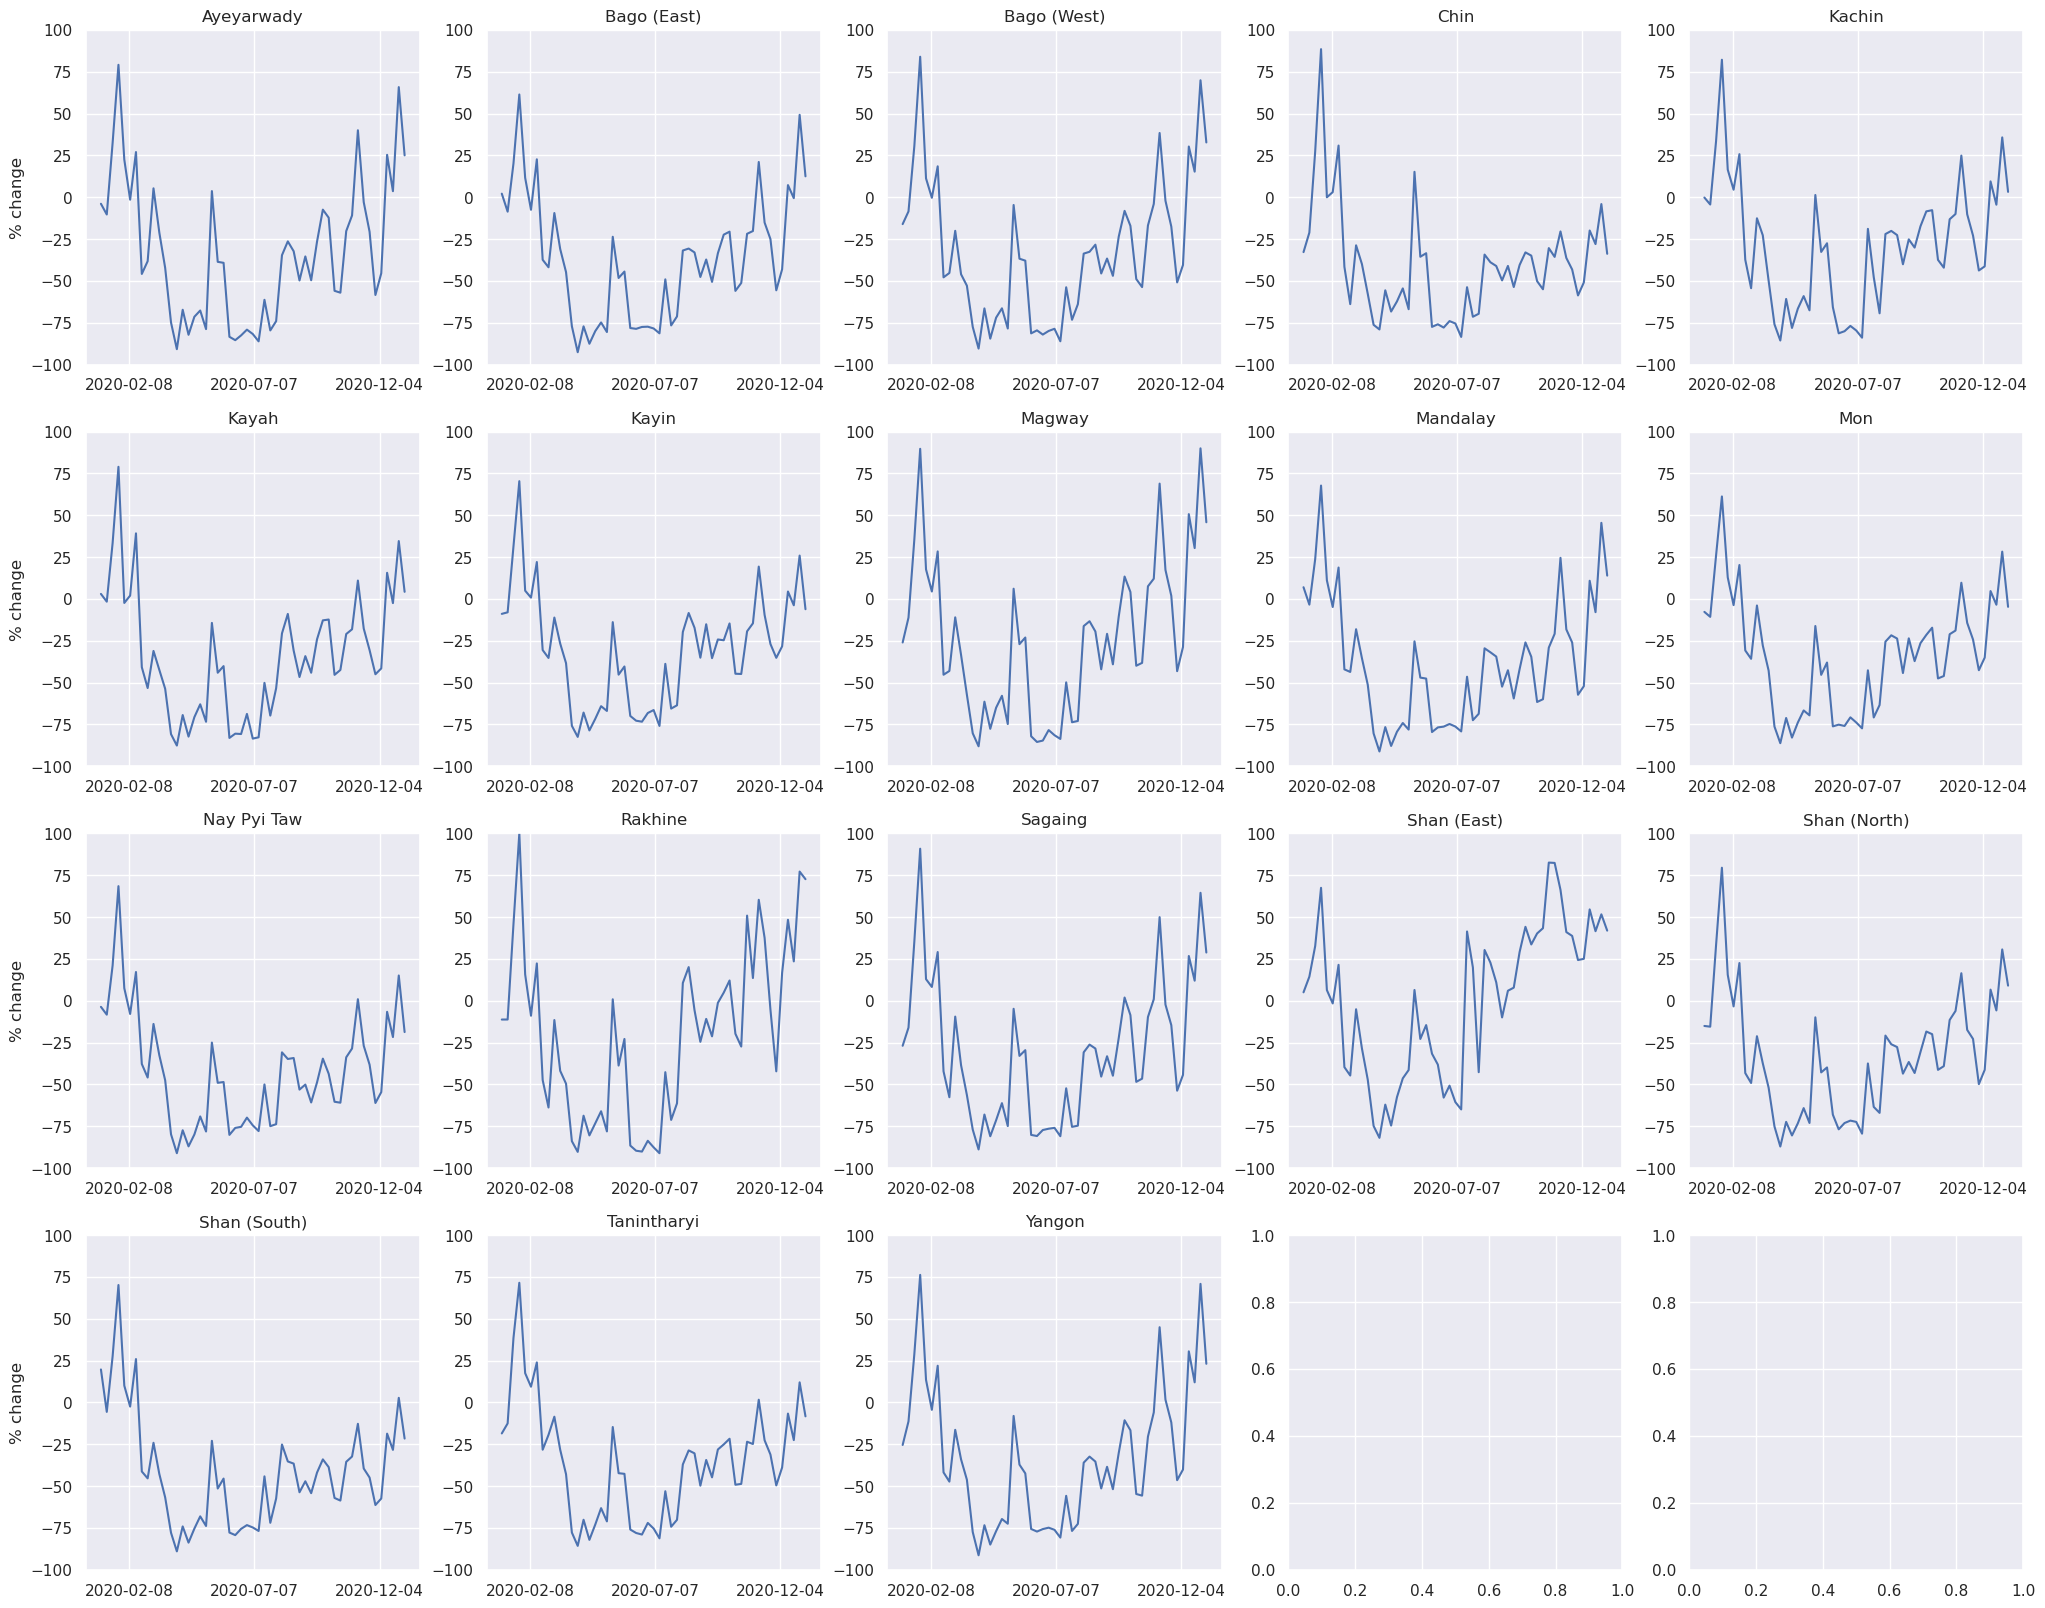

In [28]:
FREQ = "W"

data = ACTIVITY.groupby(["date", "admin1"])["percent_change"].mean().to_frame()
data = data.pivot_table(values=["percent_change"], index=["date"], columns=["admin1"])
data.columns = [x[1] for x in data.columns]
data.index = pd.to_datetime(data.index)
data = data.groupby(pd.Grouper(freq=FREQ)).mean()

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
count = 0
names = data.columns
for i in range(12):
    for j in range(5):
        ax[i, j].plot(data[names[count]])
        ax[i, j].title.set_text(names[count])
        ax[i, j].set_ylim([-100, 100])
        ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

        count += 1
        if j == 0:
            ax[i, j].set_ylabel("% change")
        if count > 17:
            break
    if count > 17:
        break
plt.savefig("percentage_change_admin1.png")

#### Z-Score

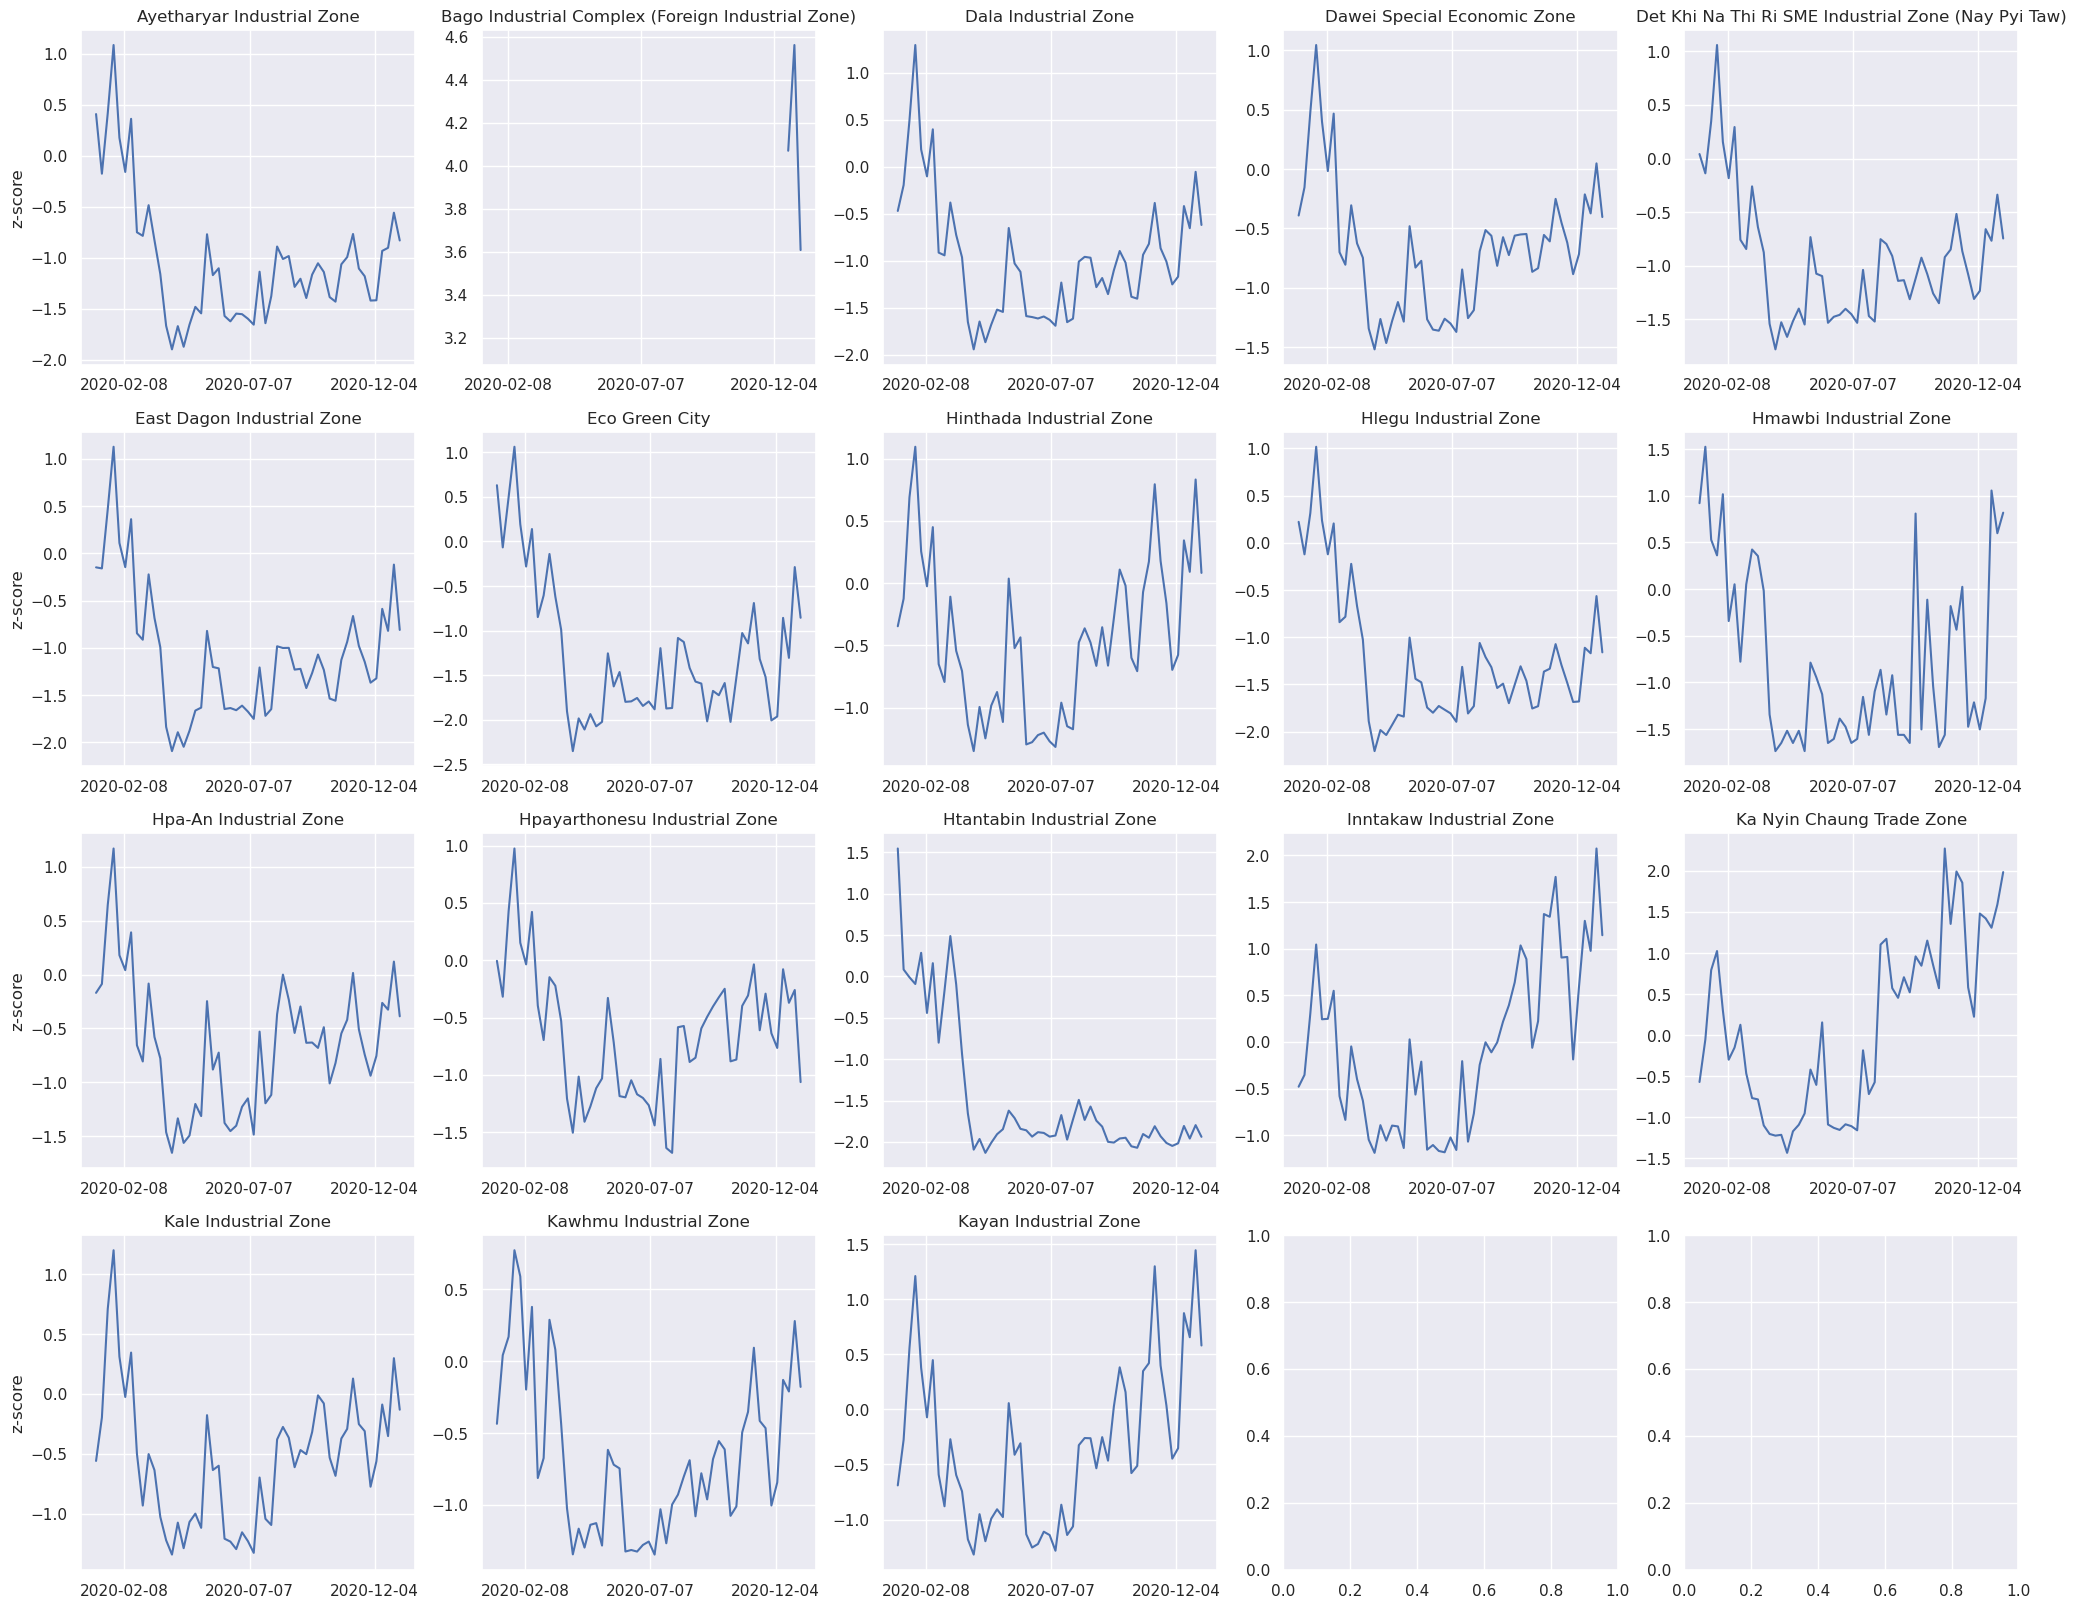

In [29]:
FREQ = "W"

data = ACTIVITY.groupby(["date", "Name"])["z_score"].mean().to_frame()
data = data.pivot_table(values=["z_score"], index=["date"], columns=["Name"])
data.columns = [x[1] for x in data.columns]
data.index = pd.to_datetime(data.index)
data = data.groupby(pd.Grouper(freq=FREQ)).mean()

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
count = 0
names = data.columns
for i in range(12):
    for j in range(5):
        ax[i, j].plot(data[names[count]])
        ax[i, j].title.set_text(names[count])
        ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

        count += 1
        if j == 0:
            ax[i, j].set_ylabel("z-score")
        if count > 17:
            break
    if count > 17:
        break
plt.savefig("z_score_admin1.png")

### By Region

In [30]:
import numpy as np

region_dict = {
    "Kachin": "North",
    "Shan (North)": "North",
    "Sagaing": "Central",
    "Magway": "Central",
    "Mandalay": "Central",
    "Mon": "South",
    "Kayin": "South",
    "Kayah": "South",
    "Tanintharyi": "South",
    "Bago (East)": "South",
    "Rakhine": "West",
    "Chin": "West",
    "Yangon": "Other",
    "Ayeyarwady": "Other",
    "Nay Pyi Taw": "Other",
    "Bago (West)": "Other",
    "Shan (South)": "Other",
    "Shan (East)": "Other",
    np.nan: np.nan,
}
ACTIVITY["region"] = ACTIVITY["admin1"].apply(lambda x: region_dict[x])

#### Percentage Change

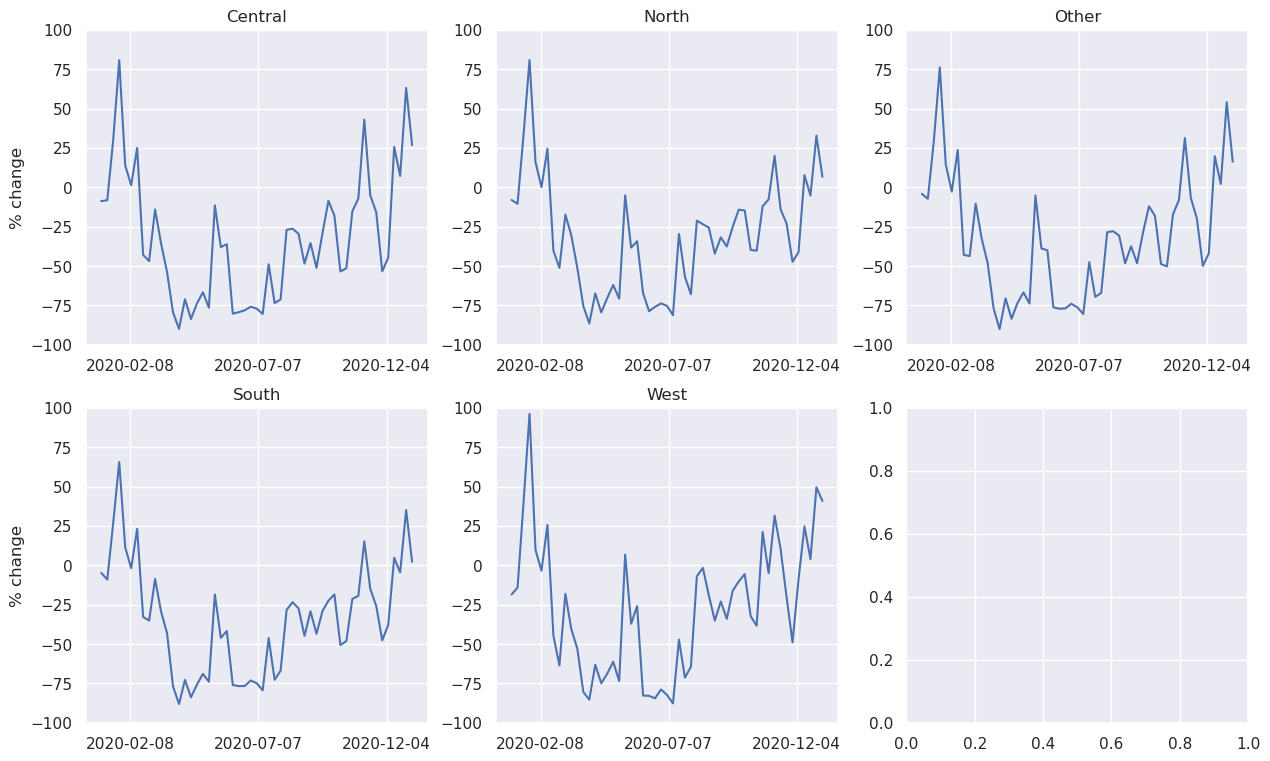

In [38]:
FREQ = "W"

data = ACTIVITY.groupby(["date", "region"])["percent_change"].mean().to_frame()
data = data.pivot_table(values=["percent_change"], index=["date"], columns=["region"])
data.columns = [x[1] for x in data.columns]
data.index = pd.to_datetime(data.index)
data = data.groupby(pd.Grouper(freq=FREQ)).mean()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
count = 0
names = data.columns
for i in range(2):
    for j in range(3):
        ax[i, j].plot(data[names[count]])
        ax[i, j].title.set_text(names[count])
        ax[i, j].set_ylim([-100, 100])
        ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

        count += 1
        if j == 0:
            ax[i, j].set_ylabel("% change")
        if count > 4:
            break
    if count > 4:
        break
plt.savefig("percentage_change_region.png")

#### Z-Score

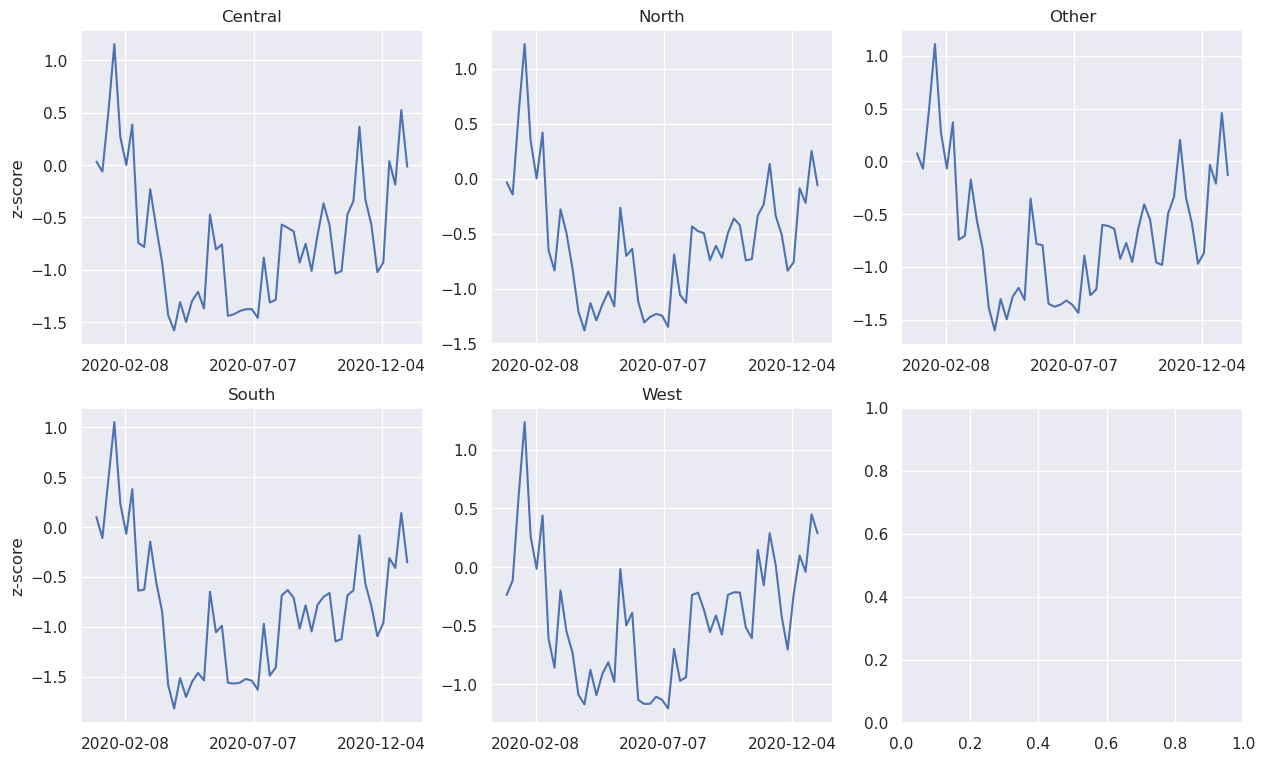

In [37]:
FREQ = "W"

data = ACTIVITY.groupby(["date", "region"])["z_score"].mean().to_frame()
data = data.pivot_table(values=["z_score"], index=["date"], columns=["region"])
data.columns = [x[1] for x in data.columns]
data.index = pd.to_datetime(data.index)
data = data.groupby(pd.Grouper(freq=FREQ)).mean()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
count = 0
names = data.columns
for i in range(2):
    for j in range(3):
        ax[i, j].plot(data[names[count]])
        ax[i, j].title.set_text(names[count])
        # ax[i,j].set_title(names[count], fontsize = 20)
        ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

        count += 1
        if j == 0:
            ax[i, j].set_ylabel("z-score")
        if count > 4:
            break
    if count > 4:
        break
plt.savefig("z_score_region.png")

## Limitations

The methodology presented is an exploratory analysis pilot aiming to shed light on the economic situation in Syria and Türkiye leveraging alternative data, especially when we are confronted with the absence of traditional data and methods. Mobility data, like any other type of data, comes with limitations and underlying assumptions that should be considered when interpreting and using the data. 

```{caution}
Here are some common limitations and assumptions associated with mobility data:

**Limitations:**

 - **Sampling Bias:** Mobility data is primarily collected through convenience sampling and lacks the controlled methodology of randomized trials. 
 
 - **Selection Bias:** Users who opt to share their mobility data may not be representative of the entire population, potentially introducing selection bias.

 - **Privacy Concerns:** The collection of mobility data may raise privacy issues, as it can sometimes be linked to individuals, potentially violating their privacy.

  - **Data Quality:** Data quality can vary, and errors, inaccuracies, or missing data points may be present, which can affect the reliability of analyses.
  
 - **Temporal and Spatial Resolution:** Mobility data may not capture all movements or may lack fine-grained temporal or spatial resolution, limiting its utility for some applications.
 
 - **Lack of Contextual Information:** Mobility data primarily captures movement patterns and geolocation information. It may lack other crucial contextual information, such as transactional data, business types, or specific economic activities, which are essential for accurate estimation of economic activity.
 
 - **Private Intent Data:** The methodology relies on private intent data. In other words, the input data, i.e. the mobility data, was not produced or collected to analyze the population of interest or address the research question as its primary objective but it was repurposed for the public good. The benefits and caveats when using private intent data have been discussed extensively in the [World Development Report 2021](https://wdr2021.worldbank.org) {cite}`WorldBank2021WorldDevelopmentReport`.
 
**Assumptions:**

 - **Homogeneity:** Mobility data often assumes that the mobility patterns of individuals or groups are relatively consistent over time and space, which may not always be the case.

 - **Consistency in Data Sources:** Mobility data may assume consistency in data sources and methodologies across different regions or datasets, which may not always hold true.

 - **User Behavior:** Assumptions about user behavior, such as the purpose of travel or preferred routes, are often made when interpreting mobility data.

 - **Implicit Data Interpretation:** Interpretation of mobility data often assumes that certain behaviors or patterns observed in the data have a specific meaning, which may not always be accurate without additional context.

 - **App Usage as a Proxy:** In some cases, the use of specific apps or devices may be used as a proxy for mobility data, assuming that it accurately represents individual movements.
```

It's important to be aware of these limitations and assumptions when working with mobility data and to consider their potential impact on the conclusions drawn from the data. Additionally, researchers and analysts should explore ways to address these limitations and validate assumptions when conducting mobility data analyses.

```{seealso}
For further discussion on limitations and assumptions, please check out the [Development Data Partnership Documentation on Mobility Data](https://docs.datapartnership.org/collections/mobility/README.md).
```

## References

```{bibliography}
:filter: docname in docnames
```
